In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error as MSE

波士顿房价数据集

In [3]:
boston = load_boston()
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [4]:
boston.data.shape

(506, 13)

In [5]:
boston.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [7]:
data = pd.DataFrame(boston.data, columns = boston.feature_names)
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [10]:
X = data
y = boston.target

In [11]:
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y, test_size=0.3, random_state=29)

In [15]:
print(Xtrain.shape)
print(Xtest.shape)

(354, 13)
(152, 13)


-----

XGBoost的两种接口

### xgb接口

In [17]:
import xgboost as xgb

In [18]:
dtrain = xgb.DMatrix(Xtrain, ytrain)
dtest = xgb.DMatrix(Xtest,ytest)

+ 配置参数，下面的参数都是默认值，只不过显式写出来了

In [47]:
# 这个params字段里配置的是 Booster 类的参数
params = {'booster':'gbtree',  #基分类器
          'objective': 'reg:squarederror', #目标函数
         'eta': 0.3,  #学习速率
         'gamma': 0,  #分咧的最小增益
         'max_depth': 6,  #树的最大深度
         'lambda': 1,  #L2正则项系数
         'alpha': 0,  # L1正则项系数
         'subsample': 1,  #boostrap是的采样比例
         'tree': 'auto',  # 树的生成方式
         'base_score': 0.5,  # 生成第一棵树时的初始值
         'eval_metric': ['rmse','mae']}  # 在 验证集 上进行评估的指标，可以选择多个

# booster的个数
num_round = 10

# 用于训练时查看验证集上效果的 evals (list of pairs (DMatrix, string)) 
watch_list = [(dtrain, 'train'), (dtest, 'eval')]

+ 训练模型

In [48]:
bst = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_round
                , evals=watch_list
               )

[0]	train-rmse:17.0962	train-mae:15.5753	eval-rmse:17.0354	eval-mae:15.4794
[1]	train-rmse:12.3508	train-mae:11.0463	eval-rmse:12.3715	eval-mae:10.9618
[2]	train-rmse:8.97849	train-mae:7.8587	eval-rmse:9.14436	eval-mae:7.82454
[3]	train-rmse:6.59204	train-mae:5.60841	eval-rmse:7.02082	eval-mae:5.72816
[4]	train-rmse:4.90564	train-mae:4.04055	eval-rmse:5.58317	eval-mae:4.32838
[5]	train-rmse:3.71914	train-mae:2.9316	eval-rmse:4.7071	eval-mae:3.47626
[6]	train-rmse:2.88353	train-mae:2.20503	eval-rmse:4.21405	eval-mae:3.0341
[7]	train-rmse:2.286	train-mae:1.71135	eval-rmse:3.85263	eval-mae:2.74129
[8]	train-rmse:1.90478	train-mae:1.41127	eval-rmse:3.65708	eval-mae:2.58219
[9]	train-rmse:1.6064	train-mae:1.19197	eval-rmse:3.55004	eval-mae:2.48576


### Sklearn接口

In [ ]:
from xgboost import XGBRegressor as XGBR

In [75]:
xgbr = XGBR(n_estimators=100)
xgbr.fit(Xtrain,ytrain)

[13:59:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [76]:
# 这里默认返回的是R^2，不是MSE，可使用shift + tab查看签名
xgbr.score(Xtest,ytest)

0.8602355309236762

In [77]:
ytest.mean()

22.650000000000002

In [78]:
# MSE占到了均值的接近50%，效果不太好
MSE(ytest, xgbr.predict(Xtest))

11.135163981742757

In [79]:
xgbr.feature_importances_

array([0.04097971, 0.00196055, 0.01399265, 0.0260286 , 0.02934796,
       0.22701843, 0.00805854, 0.04400521, 0.01526619, 0.01207243,
       0.03462191, 0.01319523, 0.5334527 ], dtype=float32)

交叉验证效果

In [80]:
xgbr = XGBR(n_estimators=100)
cross_val_score(xgbr,X,y,cv=5)

[13:59:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:59:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:59:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:59:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:59:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


array([0.77955736, 0.85656904, 0.79106707, 0.57326677, 0.41285553])

In [81]:
# 查看sklearn中已有的指标
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [82]:
# 使用其他指标
cross_val_score(xgbr,X,y,cv=5,scoring='neg_mean_squared_error')

[13:59:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:59:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:59:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:59:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:59:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


array([ -7.61302966, -13.05748854, -16.73285435, -37.42956222,
       -15.6111833 ])

使用随机森林和线性回归作对比

In [83]:
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import KFold

In [84]:
lr = LinearRegression()
rf = RFR(n_estimators=20)

In [85]:
lr.fit(Xtrain,ytrain)
lr.score(Xtest,ytest)

0.7769540740816121

In [86]:
cross_val_score(lr, X, y, cv=5)

array([ 0.63919994,  0.71386698,  0.58702344,  0.07923081, -0.25294154])

In [87]:
rf.fit(Xtrain,ytrain)
rf.score(Xtest,ytest)

0.8165086668186075

In [88]:
cross_val_score(rf,X,y,cv=5)

array([0.74786905, 0.83483759, 0.74464522, 0.45112138, 0.38153122])

观察n_estimator的学习曲线

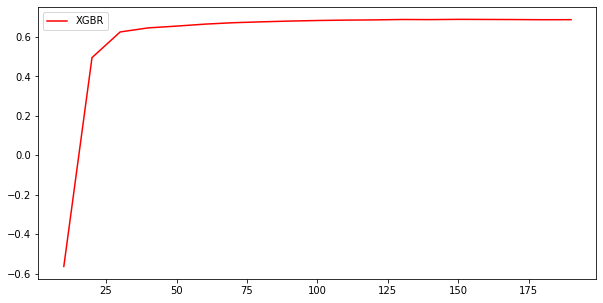

In [89]:
n_estimator_range = range(10, 200, 10)
score = []
for n_estimator in n_estimator_range:
    xgbr = XGBR(n_estimators=n_estimator, silent=True)
    result = cross_val_score(xgbr, X, y, cv=5).mean()
    score.append(result)
    
plt.figure(figsize=(10,5))
plt.plot(n_estimator_range, score, c='red', label='XGBR')
plt.legend()

In [90]:
print(n_estimator_range[score.index(max(score))], max(score))

150 0.6885265739694534


重新绘制带方差和偏差的学习曲线

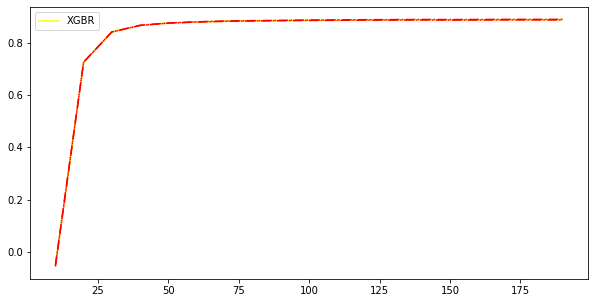

In [91]:
n_estimator_range = range(10, 200, 10)
cv = KFold(n_splits=5, shuffle=True, random_state=29)
score = []
var = []
ge = []

for n_estimator in n_estimator_range:
    xgbr = XGBR(n_estimators=n_estimator, silent=True)
    cv_result = cross_val_score(xgbr, X, y, cv=cv)
    score.append(cv_result.mean())
    var.append(cv_result.var())
    ge.append((1 - cv_result.mean())**2 + cv_result.var())

score = np.array(score)
var = np.array(var)

plt.figure(figsize=(10,5))
plt.plot(n_estimator_range, score, c='yellow', label='XGBR')
# 添加方差线
plt.plot(n_estimator_range, score-var, c='red', linestyle='-.')
plt.plot(n_estimator_range, score+var, c='red', linestyle='-.')
plt.legend()

调整增益参数$\gamma$
需要使用xgboost本身库里的xgboost.cv来查看效果

In [92]:
import xgboost as XGB

from time import time
from datetime import datetime

首先练习使用xgboost.cv()函数

In [93]:
data = XGB.DMatrix(X,y)
param = {'silent':True, 'obj':'reg:linear', 'gamma':0}
num_round = 180
n_fold = 5

In [94]:
time0 = time()
cv_result = XGB.cv(params=param, dtrain=data, num_boost_round=num_round, nfold=n_fold)
time_diff = time() - time0
print("running time : " + datetime.fromtimestamp(time_diff).strftime('%M:%S:%f'))

running time : 00:00:679215


In [95]:
type(cv_result)

pandas.core.frame.DataFrame

In [96]:
cv_result.__class__

pandas.core.frame.DataFrame

In [97]:
cv_result

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,17.105577,0.129117,17.163215,0.584297
1,12.337972,0.097556,12.519736,0.473458
2,8.994071,0.065756,9.404534,0.472310
3,6.629480,0.050323,7.250335,0.500342
4,4.954407,0.033209,5.920812,0.591874
...,...,...,...,...
175,0.001299,0.000289,3.669898,0.857676
176,0.001285,0.000261,3.669897,0.857677
177,0.001275,0.000239,3.669903,0.857669
178,0.001263,0.000217,3.669901,0.857672


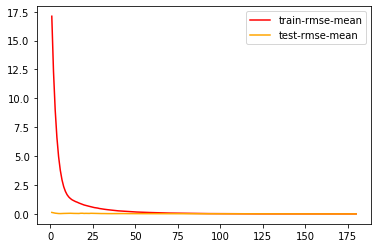

In [98]:
plt.plot(range(1, 181), cv_result.iloc[:,0], c='red', label="train-rmse-mean")
plt.plot(range(1,181), cv_result.iloc[:,1], c='orange', label='test-rmse-mean')
plt.legend()

使用xgboost.cv来调整$\gamma$

In [99]:
num_round = 180
n_fold = 5
param1 = {'silent':True, 'obj':'reg:linear', 'gamma':0}
param2 = {'silent':True, 'obj':'reg:linear', 'gamma':20}

cv_result1 = XGB.cv(params=param1, dtrain=data, num_boost_round=num_round, nfold=n_fold)
cv_result2 = XGB.cv(params=param2, dtrain=data, num_boost_round=num_round, nfold=n_fold)

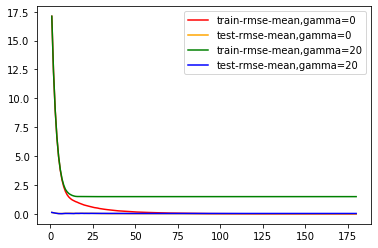

In [100]:
plt.plot(range(1, 181),cv_result1.iloc[:,0], c='red', label="train-rmse-mean,gamma=0")
plt.plot(range(1,181), cv_result1.iloc[:,1], c='orange', label='test-rmse-mean,gamma=0')
plt.plot(range(1,181), cv_result2.iloc[:,0], c='green', label="train-rmse-mean,gamma=20")
plt.plot(range(1,181), cv_result2.iloc[:,1], c='blue', label='test-rmse-mean,gamma=20')
plt.legend()